In [1]:
# core
import sys
import warnings
from IPython import sys_info

# data science
import pandas as pd
import numpy as np
from scipy.stats import norm

# Cloud integration
from azureml.core import Workspace, Dataset, ComputeTarget, VERSION as aml_version
print(f'Azure ML SDK v{aml_version}')
# plots
import matplotlib.pyplot as plt
import seaborn as sns

# show info about python env
print(sys_info())
warnings.filterwarnings("ignore")

Azure ML SDK v1.36.0
{'commit_hash': '980a41b',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython',
 'ipython_version': '7.31.0',
 'os_name': 'posix',
 'platform': 'Linux-5.4.0-1063-azure-x86_64-with-glibc2.10',
 'sys_executable': '/anaconda/envs/azureml_py38/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.12 | packaged by conda-forge | (default, Oct 12 2021, '
                '21:57:06) \n'
                '[GCC 9.4.0]'}


In [2]:
n_days = int(252)  # US market has 252 trading days in a year
n_simulations = int(1e4)  # number of Monte-Carlo simulations

# The most promised currencies (copy this list from fx_currencies_analysis.Rmd)
symbols = [
    'USD/AED', 'USD/AUD', 'USD/CHF', 'USD/CNY', 'USD/EUR', 'USD/GBP', 
    'USD/HKD', 'USD/JPY', 'USD/KZT', 'USD/MXN', 'USD/RUB', 'USD/SEK', 'USD/SGD'
]

In [3]:
ws =  Workspace.from_config()
print(f"Connected to *{ws.get_details()['friendlyName']}* workspace in *{ws.get_details()['location']}*.")

print('Compute Targets:')
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print('\t', compute.name, ':', compute.type)

# > htop

Connected to *portf-opt-ws* workspace in *westeurope*.
Compute Targets:
	 demo-vm : ComputeInstance


In [4]:
currencies_ds = Dataset.get_by_name(ws, name='Currencies')
currencies_ds.to_pandas_dataframe()

print(f'Dataset name: {currencies_ds.name}. Description: {currencies_ds.description}.')
print(f'Size of Azure ML dataset object: {sys.getsizeof(currencies_ds)} bytes.')

Dataset name: Currencies. Description: Source: https://www.kaggle.com/datasets/dhruvildave/currency-exchange-rates.
Size of Azure ML dataset object: 48 bytes.


In [5]:
quotes_df = (currencies_ds
    # materialize
    .to_pandas_dataframe()
    # define format
    .rename(columns={'slug': 'symbol'})
    .loc[:, ['symbol', 'date', 'close']]
    # filter
    .query("symbol in @symbols")
    .query("date > '2012-01-01'")
    # set time index
    .set_index('date')
    .sort_values(by='date'))

quotes_df

,symbol,close
date,,
2012-01-02,USD/GBP,0.644660
2012-01-02,USD/EUR,0.771600
2012-01-02,USD/KZT,175.919998
2012-01-02,USD/RUB,31.988701
2012-01-02,USD/SEK,6.876300
...,...,...
2021-08-30,USD/AUD,1.369950
2021-08-30,USD/SGD,1.344480
2021-08-30,USD/EUR,0.847000


In [6]:
quotes_df.groupby('symbol')['close'].agg(['count', 'last'])

,count,last
symbol,,
USD/AED,2499,3.672800
USD/AUD,2496,1.369950
USD/CHF,2494,0.916910
USD/CNY,2496,6.465800
USD/EUR,2496,0.847000
USD/GBP,2497,0.726610
USD/HKD,2496,7.786940
USD/JPY,2497,109.902000
USD/KZT,2497,427.179993


In [7]:
usdrub_df = quotes_df[quotes_df.symbol == 'USD/RUB']
usdrub_df

,symbol,close
date,,
2012-01-02,USD/RUB,31.988701
2012-01-03,USD/RUB,31.988701
2012-01-04,USD/RUB,31.749001
2012-01-05,USD/RUB,31.751301
2012-01-06,USD/RUB,32.002602
...,...,...
2021-08-24,USD/RUB,74.080498
2021-08-25,USD/RUB,73.761497
2021-08-26,USD/RUB,73.769997


In [8]:
def calc_returns(close_prices: pd.Series) -> pd.Series:
    """Calculate Investment Return"""
    return (close_prices/close_prices.shift()) - 1


usdrub_df['diff'] = usdrub_df['close'].diff()
usdrub_df['return'] = calc_returns(usdrub_df['close'])

usdrub_df[['close', 'diff', 'return']].tail(10)

,close,diff,return
date,,,
2021-08-17,73.282700,0.132599,0.001813
2021-08-18,73.595703,0.313004,0.004271
2021-08-19,73.843498,0.247795,0.003367
2021-08-20,74.275101,0.431602,0.005845
2021-08-23,74.195099,-0.080002,-0.001077
2021-08-24,74.080498,-0.114601,-0.001545
2021-08-25,73.761497,-0.319000,-0.004306
2021-08-26,73.769997,0.008499,0.000115
2021-08-27,74.267502,0.497505,0.006744


In [9]:
def calc_log_returns(return_prices: pd.Series) -> pd.Series:
    """Calculate Log Return"""
    return np.log(1 + return_prices)

usdrub_df['log_return'] = usdrub_df['return'].apply(lambda x: calc_log_returns(x))

usdrub_df[['close', 'diff', 'return', 'log_return']].tail(10)

,close,diff,return,log_return
date,,,,
2021-08-17,73.282700,0.132599,0.001813,0.001811
2021-08-18,73.595703,0.313004,0.004271,0.004262
2021-08-19,73.843498,0.247795,0.003367,0.003361
2021-08-20,74.275101,0.431602,0.005845,0.005828
2021-08-23,74.195099,-0.080002,-0.001077,-0.001078
2021-08-24,74.080498,-0.114601,-0.001545,-0.001546
2021-08-25,73.761497,-0.319000,-0.004306,-0.004315
2021-08-26,73.769997,0.008499,0.000115,0.000115
2021-08-27,74.267502,0.497505,0.006744,0.006721


In [10]:
def calc_simulated_returns(log_returns: pd.Series, n_days: int, n_iterations: int) -> pd.Series:
    """Calculate Simulated Return"""

    u = log_returns.mean()
    var = log_returns.var()
    stdev = log_returns.std()

    drift = u - (0.5*var)
    Z = norm.ppf(np.random.rand(n_days, n_iterations))

    return np.exp(drift + stdev*Z)


usdrub_simulated_returns = calc_simulated_returns(
    usdrub_df['log_return'].dropna(),
    n_days,
    n_simulations)

assert(
    usdrub_simulated_returns.shape == (n_days, n_simulations)
    and (usdrub_simulated_returns > 0).all()
    and (usdrub_simulated_returns < 2).all()
)

In [11]:
def get_breakeven_prob(pred, risk_free_rate: float = 0.02) -> pd.Series:
    """
    Calculation of the probability of a stock being above a certain threshold,
    which can be defined as a value (final stock price) or return rate (percentage change).
    """

    init_pred = pred.iloc[0, 0]

    last_pred = pred.iloc[-1]
    pred_list = list(last_pred)

    over = [(p*100)/init_pred for p in pred_list if ((p-init_pred)*100)/init_pred >= risk_free_rate]
    less = [(p*100)/init_pred for p in pred_list if ((p-init_pred)*100)/init_pred < risk_free_rate]

    return len(over)/(len(over) + len(less))


def evaluate_simulation(simulated_returns: pd.Series, last_actual_price: float, n_days: int, plot: bool = True) -> pd.DataFrame:
    """
    Evaluate Monte-Carlo simulations result
    """

    # Create empty matrix
    price_list = np.zeros_like(simulated_returns)

    # Put the last actual price in the first row,
    # and calculate the price of each day
    price_list[0] = last_actual_price
    for t in range(1, n_days):
        price_list[t] = price_list[(t - 1)]*simulated_returns[t]

    # convert to temp dataframe
    price_df = pd.DataFrame(price_list)

    # Plot
    if plot == True:
        x = price_df.iloc[-1]
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative': True}, kde_kws={'cumulative':True}, ax=ax[1])
        plt.xlabel('Stock Price')
        plt.show()

    print('Results:')
    print(f'\tInvestment period: {n_days-1} days')
    print(f'\tExpected Value: {round(price_df.iloc[-1].mean(), 2)} per USD')
    print(f'\tReturn: {round(100*(price_df.iloc[-1].mean() - price_list[0,1])/price_df.iloc[-1].mean(), 2)}%')
    print(f'\tProbability of Breakeven: {get_breakeven_prob(price_df)}')

    return price_df

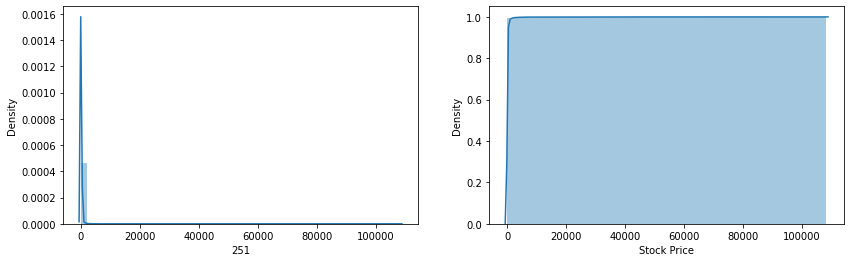

Results:
	Investment period: 251 days
	Expected Value: 94.7 per USD
	Return: 22.38%
	Probability of Breakeven: 0.1534


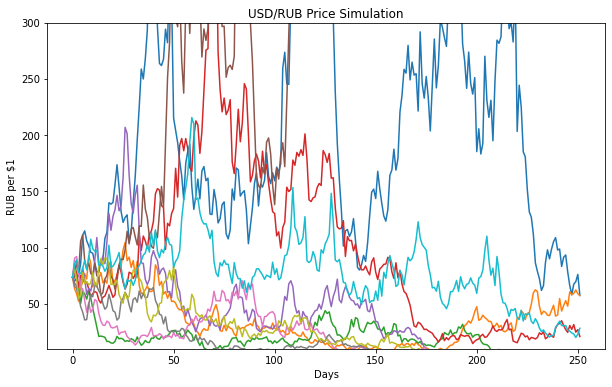

In [12]:
usdrub_mc_simulation_df = evaluate_simulation(
    usdrub_simulated_returns,
    last_actual_price=usdrub_df['close'].tail(1),
    n_days=n_days)


plt.figure(figsize=(10, 6))
plt.plot(usdrub_mc_simulation_df.sample(10, axis='columns'))
plt.title('USD/RUB Price Simulation')
plt.xlabel('Days')
plt.ylabel('RUB per $1')
plt.ylim(10, 300)
plt.show()

---- Starting Monte-Carlo simulation for ['USD/GBP'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 0.73 per USD
	Return: 1.06%
	Probability of Breakeven: 0.531


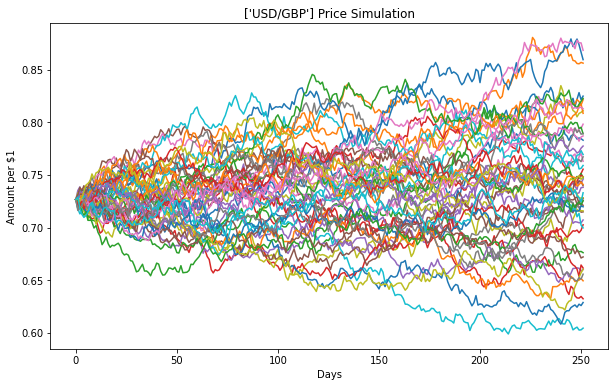

---- Starting Monte-Carlo simulation for ['USD/EUR'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 0.86 per USD
	Return: 1.01%
	Probability of Breakeven: 0.5308


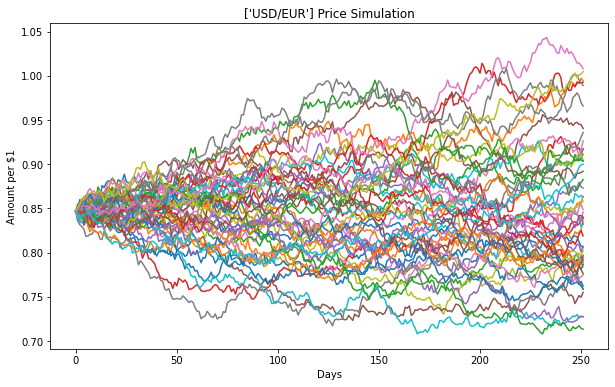

---- Starting Monte-Carlo simulation for ['USD/KZT'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 467.32 per USD
	Return: 8.59%
	Probability of Breakeven: 0.7275


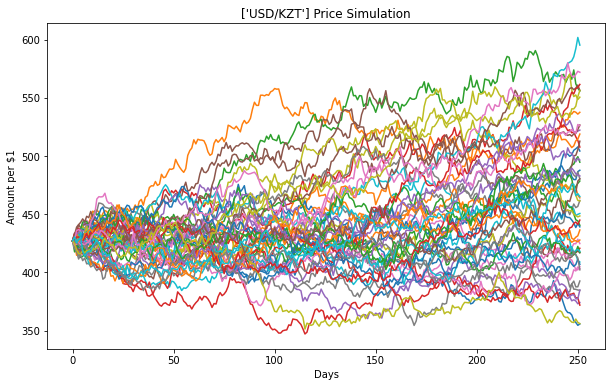

---- Starting Monte-Carlo simulation for ['USD/RUB'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 75.94 per USD
	Return: 3.2%
	Probability of Breakeven: 0.1599


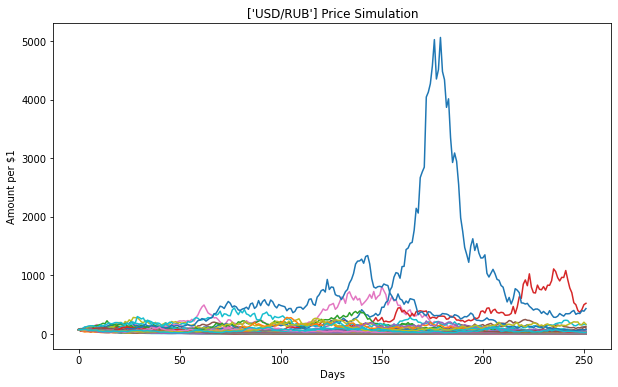

---- Starting Monte-Carlo simulation for ['USD/SEK'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 8.81 per USD
	Return: 2.19%
	Probability of Breakeven: 0.5635


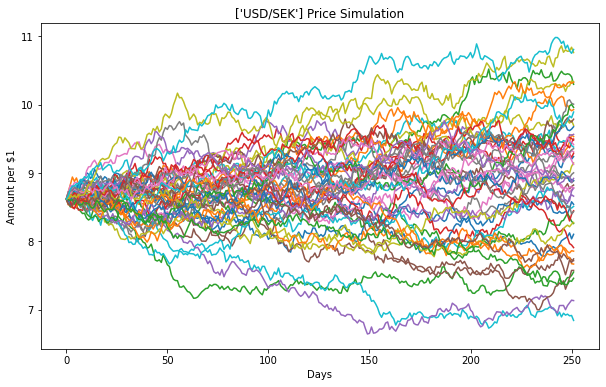

---- Starting Monte-Carlo simulation for ['USD/SGD'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 1.35 per USD
	Return: 0.51%
	Probability of Breakeven: 0.5326


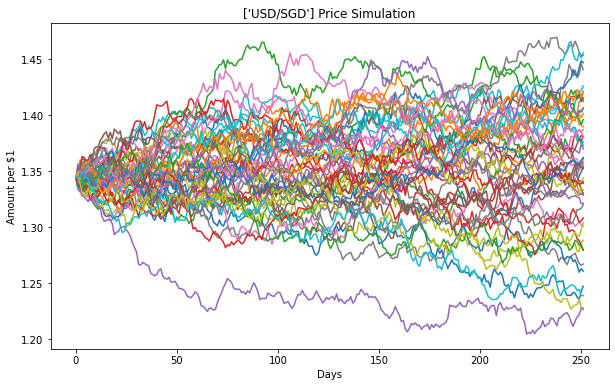

---- Starting Monte-Carlo simulation for ['USD/CHF'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 0.91 per USD
	Return: -0.23%
	Probability of Breakeven: 0.4749


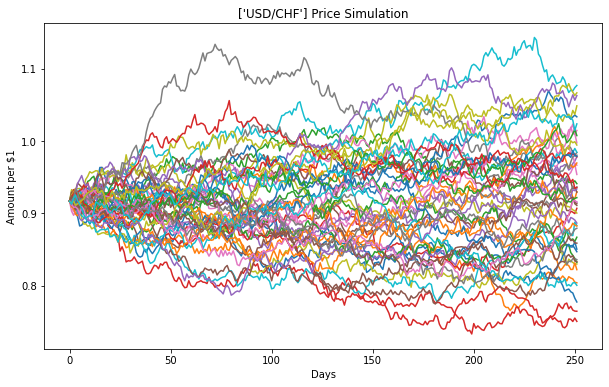

---- Starting Monte-Carlo simulation for ['USD/HKD'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 7.79 per USD
	Return: 0.02%
	Probability of Breakeven: 0.4988


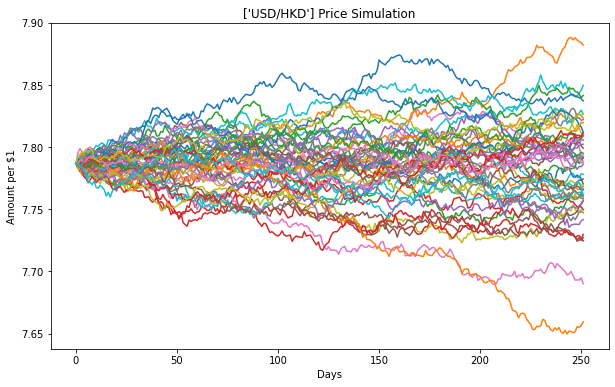

---- Starting Monte-Carlo simulation for ['USD/AED'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 3.67 per USD
	Return: -0.0%
	Probability of Breakeven: 0.4536


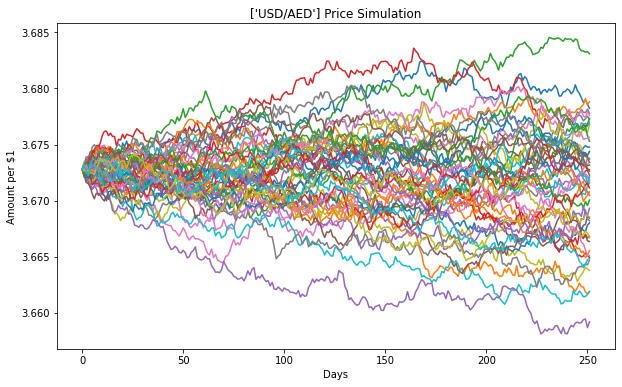

---- Starting Monte-Carlo simulation for ['USD/CNY'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 6.48 per USD
	Return: 0.27%
	Probability of Breakeven: 0.5249


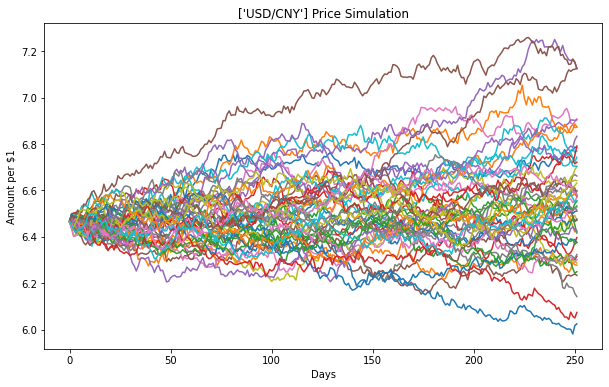

---- Starting Monte-Carlo simulation for ['USD/MXN'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 20.87 per USD
	Return: 3.53%
	Probability of Breakeven: 0.588


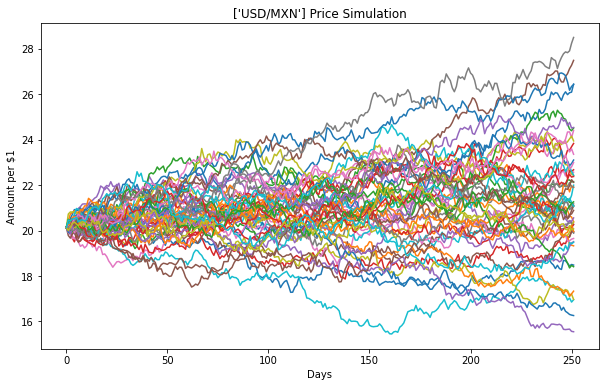

---- Starting Monte-Carlo simulation for ['USD/JPY'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 113.83 per USD
	Return: 3.45%
	Probability of Breakeven: 0.6372


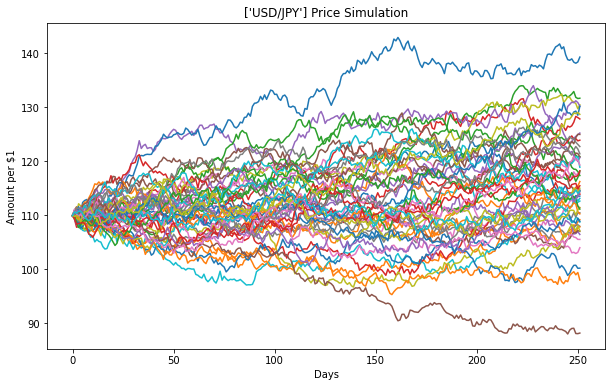

---- Starting Monte-Carlo simulation for ['USD/AUD'] symbol ----
Results:
	Investment period: 251 days
	Expected Value: 1.42 per USD
	Return: 3.45%
	Probability of Breakeven: 0.6209


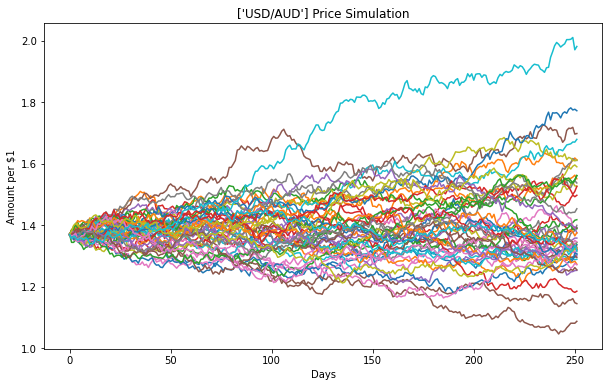

In [13]:
# 1. prepare
quotes_data = [quotes_df.query('symbol == @s') for s in quotes_df.symbol.unique()]
symbols_list = [df.symbol.unique() for df in quotes_data]

# 2. simulate
returns_data = [calc_returns(df['close']) for df in quotes_data]
log_returns_data = [calc_log_returns(r) for r in returns_data]
simulated_returns_data = [calc_simulated_returns(lr, n_days, n_simulations) for lr in log_returns_data]

assert(
    len(quotes_data) > 0
    and len(quotes_data) == len(symbols_list) == len(returns_data) == len(log_returns_data) == len(simulated_returns_data)
)

# 3. evaluate
for i in range(len(symbols_list)):
    print(f'---- Starting Monte-Carlo simulation for {symbols_list[i]} symbol ----')

    prices_ms = evaluate_simulation(simulated_returns_data[i], quotes_data[i]['close'].tail(1), n_days, plot=False)

    plt.figure(figsize=(10, 6))
    plt.plot(prices_ms.sample(50, axis='columns'))
    plt.title(f'{symbols_list[i]} Price Simulation')
    plt.xlabel('Days')
    plt.ylabel('Amount per $1')
    plt.show()

In [15]:
import gc
gc.collect()

18140